# Analysis of reorientation events (change in heading relative to landmark) in two-object forest conditioning paradigm
### Generate a minimal projection of the trajectory in the two-object forest.
Small triangle defined by one cone, one cylinder and the center of a square defined by two cones and two cylinders.

### Identitfy reorientation events (~ turns in 1D).

### Compute maps of the reorientation events as a function of the position in the VR where they occur. 


In [1086]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
import scipy.stats as sts
    
from os import mkdir, walk, getcwd
from os.path import sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

import warnings

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.flyTracePlots import plotPosInRange

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto'

root = Tk()
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)


 Analysing the following folders:

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30']


In [1087]:
expDirs=expDirs[:]
print(expDirs)

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30']


In [1088]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#from operator import itemgetter
#my_indices = [0, 2, 3, 7, 9, 12, 13, 14, 16, 22] #top 10 HC anti cylinder flies.
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''#'_top10'  # chose short string, to specify dataset (e.g. top5 flies)

In [1090]:
analysisDir = '/Users/haberkernh/Desktop/reorientationEventAnalysis/Gr43a-KI_x_10xChrimsonR_AntiCyliWuerzburg/'

try:
    mkdir(analysisDir)
except:
    print('Plot directory already exists')

### Compose mutli-fly data into dataframe

In [1091]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [1092]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [1093]:
dataDir.split(sep)

['',
 'Volumes',
 'jayaramanlab',
 'Hannah',
 'Projects',
 'FlyVR',
 '1_Experiments',
 'twoObjOpto',
 'Gr43a-KI_x_10xChrimsonR',
 'Data',
 'female',
 'cone_20min',
 'starved',
 'W',
 'rawData',
 '']

In [1095]:
genotype = dataDir.split(sep)[-8]#[-6]#
condition = dataDir.split(sep)[-3]#[-4]
print(genotype)
print(condition)

Gr43a-KI_x_10xChrimsonR
W


In [1096]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','condition','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsPr = 0
nTrialsTr = 0
nTrialsPo = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[6]#[-4]
        trial = FODataFiles.index(fileToAnalyse) + 1
       
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
            nTrialsTr += 1
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
            nTrialsPr += 1
        else:
            trialtype = 'post'
            rZones = 'off'
            nTrialsPo += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'condition', condition)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f01/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f01_Wf_200ms_post_out_180117190123.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f01_Wf_200ms_pre_out_180117183032.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f01_Wf_200ms_train_out_180117184057.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f02/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f02_Wf_200ms_post_out_180117200040.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f02_Wf_200ms_pre_out_1

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f15/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f15_Wf_200ms_post_out_180202195209.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f15_Wf_200ms_pre_out_180202192120.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f15_Wf_200ms_train_out_180202193148.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f16/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_5-6d_24h_f16_Wf_200ms_post_out_180212192409.txt', 'twoObjectForest_1cm4cmConez1R_0

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f29/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-7d_24h_f29_Wf_200ms_post_out_180219194547.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-7d_24h_f29_Wf_200ms_pre_out_180219191418.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-7d_24h_f29_Wf_200ms_train_out_180219192521.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/Data/female/cone_20min/starved/W/rawData/f30/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-7d_24h_f30_Wf_200ms_post_out_180219203746.txt', 'twoObjectForest_1cm4cmConez1R_0

In [1097]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,reinforcement,condition,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,W,1.0,-0.000004,-0.692169,0.000000,13.082651,60.622000,60.622000,35.000000,35.000000,0.0
1,f01,1.0,post,off,W,1.0,-0.034613,-0.721438,0.050001,6.773013,61.275978,61.275978,34.985085,34.985085,0.0
2,f01,1.0,post,off,W,1.0,-0.070686,-0.471228,0.100002,8.062588,61.611715,61.611715,34.940698,34.940698,0.0
3,f01,1.0,post,off,W,1.0,-0.094248,-0.471228,0.150003,6.569381,62.008567,62.008567,34.869780,34.869780,0.0
4,f01,1.0,post,off,W,1.0,-0.117810,-0.392690,0.200005,5.645160,62.336100,62.336100,34.844900,34.844900,0.0
5,f01,1.0,post,off,W,1.0,-0.137445,-0.157076,0.250006,6.145141,62.618109,62.618109,34.832891,34.832891,0.0
6,f01,1.0,post,off,W,1.0,-0.145299,-0.157076,0.300007,5.310494,62.925300,62.925300,34.839600,34.839600,0.0
7,f01,1.0,post,off,W,1.0,-0.153153,0.000000,0.350008,7.444997,63.183200,63.183200,34.902800,34.902800,0.0
8,f01,1.0,post,off,W,1.0,-0.153153,-0.078538,0.400009,6.230040,63.555400,63.555400,34.896200,34.896200,0.0
9,f01,1.0,post,off,W,1.0,-0.157080,-0.078538,0.450010,6.927073,63.866900,63.866900,34.898600,34.898600,0.0


In [1098]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [1099]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'

In [1100]:
# Settings for boxplots of all three trials:

objtypeNames = ['Cone','Cylinder']

objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

In [1101]:
visitRad = 15

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

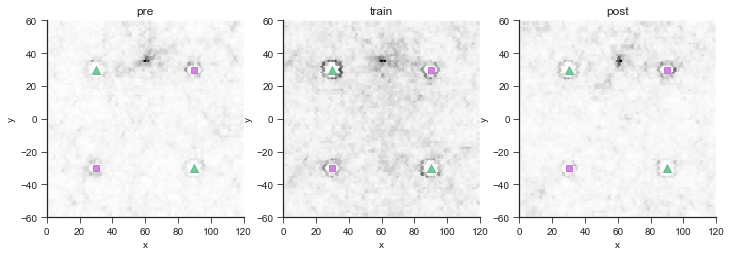

In [1102]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    
    ax.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
    ax.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
            
    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    ax.set_aspect('equal')
    myAxisTheme(ax)

## Make 2D maps of "reorientation event" parameters
### (1) Project traces to periodic grid tile
Tile = triangular zone defined by one cone, one cylinder and the center of the square formed by 4 landmarks

In [1103]:
FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,condition,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,W,1.0,-0.000004,-0.692169,0.000000,13.082651,60.622000,60.622000,35.000000,35.000000,0.0
1,f01,1.0,post,off,W,1.0,-0.034613,-0.721438,0.050001,6.773013,61.275978,61.275978,34.985085,34.985085,0.0
2,f01,1.0,post,off,W,1.0,-0.070686,-0.471228,0.100002,8.062588,61.611715,61.611715,34.940698,34.940698,0.0
3,f01,1.0,post,off,W,1.0,-0.094248,-0.471228,0.150003,6.569381,62.008567,62.008567,34.869780,34.869780,0.0
4,f01,1.0,post,off,W,1.0,-0.117810,-0.392690,0.200005,5.645160,62.336100,62.336100,34.844900,34.844900,0.0


In [1104]:
def project2triangleTile(x, y, angle, gridSize):
    """ Function to perform projection from square tile to triangle tile. 
        
        Square tile: square zone with 120 mm side length, centered on the center of 
        the square formed by 4 landmarks.
        
        Triangle tile: triangular zone defined by one cone, one cylinder and the center of 
        the square formed by 4 landmarks. The center is positioned at (0,0) and the two 
        landmarks on the right (positive x) of the center position.
    """
    
    warnings.warn("deprecated", DeprecationWarning)
    
    slct = np.arange(0,len(x)) #~np.isnan(x)
    xt = x[slct]
    yt = y[slct]
    anglet = angle[slct]
    
    # (1) cyclic shift of big square ("miniarena")
    yt = (yt + gridSize*1.5)%(gridSize*2)
    
    # (2) cross-project top 2 squares
    leftsquare = np.logical_and(yt > gridSize, xt <= gridSize)
    rightsquare = np.logical_and(yt > gridSize, xt > gridSize)
    
    yt[leftsquare] = yt[leftsquare] - gridSize
    yt[rightsquare] = yt[rightsquare] - gridSize
    
    xt[leftsquare] = xt[leftsquare] + gridSize
    xt[rightsquare] = xt[rightsquare] - gridSize
    
    # (3) flip over the edges of the rectangle parallal to y-axis --> y unchanged, correct heading angle
    tempx = xt.copy()

    xt[tempx < gridSize/2] = abs(gridSize/2 - xt[tempx < gridSize/2]) + gridSize/2
    xt[tempx >= gridSize*1.5] = gridSize*1.5 - abs(gridSize*1.5 - xt[tempx >= gridSize*1.5])
    
    xt = xt - gridSize/2
    
    # recompute angle from flipped vector
    
    #rotate and flip, rotate back
    anglet[tempx < gridSize/2] = -(np.mod(anglet[tempx < gridSize/2] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi
    anglet[tempx >= gridSize*1.5] = -(np.mod(anglet[tempx >= gridSize*1.5] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[np.logical_and(tempx < gridSize/2, angrg)] = \
            anglet[np.logical_and(tempx < gridSize/2, angrg)] + 2*np.pi
    anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] = \
            anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] + 2*np.pi
    
    
    # (4) flip lower triangle onto upper triangle (mirror along y=x diagonal)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[tempx > tempy] = tempy[tempx > tempy]
    yt[tempx > tempy] = tempx[tempx > tempy]

    #rotate and flip, rotate back
    anglet[tempx > tempy] = -(np.mod(anglet[tempx > tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] + 2*np.pi
        
    
    # (5) flip upper right trianlge onto lower left triangle (mirror along y = -x + gridsize axis)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[gridSize - tempx < tempy] = gridSize - tempy[gridSize - tempx < tempy] 
    yt[gridSize - tempx < tempy] = gridSize - tempx[gridSize - tempx < tempy]
    
    # flip parallel to x again before correcting angle
    yt = -yt + gridSize
    anglet = -anglet
    
    #rotate and flip, rotate back
    anglet[gridSize - tempx < tempy] = -(np.mod(anglet[gridSize - tempx < tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] + 2*np.pi
        
    # readjustment of triangle tile for convenience:
    xt = -xt + gridSize/2
    yt = yt - gridSize/2
    
    anglet = -(np.mod(anglet + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[angrg] =  anglet[angrg] + 2*np.pi
    
    # for convenience return the coordinates for the points defining the triangle tile
    centerPos = (0,0)
    conePos = (gridSize/2,gridSize/2)
    cyliPos = (gridSize/2,-gridSize/2)
    
    return xt, yt, anglet, centerPos, conePos, cyliPos

### (2) Compute derrived parameter and generate data frame with data in triangle tile projection

In [1105]:
#trianlge tile definition as in project2triangleTile function

# keylist of triangle tile dataframe (ttdf)
ttdf_keys = ['flyID',
             'trial',
             'rEvents',
             'moving',
             'transVelo',
             'rotVelo',
             'time',
             'xt',          # x position in triangle tile
             'yt',          # y position in triangle tile
             'alphat',      # absolute heading angle in triangle tile
             'r',           # radial distance from center point (0,0)
             'gamma',       # angular position defined by r, the x-axis and the center point
             'r_cone',      # distance to cone
             'gamma_cone',  # angular position rel. to cone
             'beta_cone',   # heading angle rel. to cone
             'r_cyli',      # distance to cylinder
             'gamma_cyli',  # angular position rel. to cylinder
             'beta_cyli']   # heading angle rel. to cylinder

In [1106]:
# define empty data frame
ttdf = pd.DataFrame(data=np.zeros((0,len(ttdf_keys))), columns=ttdf_keys)

for fly in range(numFlies):

    for tind, trialtype in enumerate(trialName):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        subdf = FOAllFlies_df.query(querystring)
        xPosTrial = subdf.iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = subdf.iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        headTrial = subdf.iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
        timeTrial = subdf.iloc[:, keyind_t:keyind_t+1].values.squeeze()

        # Project onto triangle tile
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            xt, yt, anglet, centerPos, conePos, cyliPos = project2triangleTile(xPosTrial,yPosTrial,headTrial,gridSize)

        # Compute parameters in relation to reference landmark (relative to cone or to cylinder)
        #     distance from center
        r = np.hypot(xt,yt)

        #     angular position vector gamma
        gamma =  np.sign(yt)*(np.arccos(xt/r))

        #     distance to landmark vector: d_cyli, d_cone
        #     relative heading angle beta : bt (full range), bht (half range)
        #     radial distance r from landmarks: r_cyli = np.hypot(d_cyli[0],d_cyli[1]), r_cone = ...
        d_cyli, r_cyli, beta_cyli, betah_cyli, _ = relationToObject(timeTrial, xt, yt, anglet, cyliPos)
        d_cone, r_cone, beta_cone, betah_cone, _ = relationToObject(timeTrial, xt, yt, anglet, conePos)

        gamma_cyli =  np.arccos(d_cyli[0]/r_cyli)
        gamma_cone =  np.arccos(d_cone[0]/r_cone)

        # generate dictionary:
        ttdict = {
            'xt': xt,
            'yt': yt,      
            'alphat': anglet,
            'r': r,
            'gamma': gamma,
            'r_cone': r_cone,
            'gamma_cone': gamma_cone,
            'beta_cone': betah_cone,
            'r_cyli': r_cyli,
            'gamma_cyli': gamma_cyli,
            'beta_cyli': betah_cyli
        }
        ttdf_sub = pd.DataFrame(ttdict)
        ttdf_sub.insert(0, 'flyID', flyIDs[fly])
        ttdf_sub.insert(1, 'trial', trialtype)
        ttdf_sub = pd.concat([ttdf_sub,subdf[['moving','time','rotVelo','transVelo','rEvents']]], axis=1)
        ttdf = ttdf.append(ttdf_sub)
        
ttdf = ttdf[ttdf_keys]

In [1107]:
ttdf.head()

,flyID,trial,rEvents,moving,transVelo,rotVelo,time,xt,yt,alphat,r,gamma,r_cone,gamma_cone,beta_cone,r_cyli,gamma_cyli,beta_cyli
0,f01,pre,0.0,1.0,6.732269,-0.549666,0.000000,25.000000,-0.622000,-1.570793,25.007736,-0.024875,31.027518,1.408943,2.979736,29.800451,1.402216,0.168576
1,f01,pre,0.0,1.0,4.240779,-0.157069,0.050003,25.032642,-0.957050,-1.543307,25.050930,-0.038213,31.353047,1.411693,2.955000,29.464684,1.401401,0.141907
2,f01,pre,0.0,1.0,4.514443,0.157069,0.100007,24.936279,-1.145943,-1.535453,24.962596,-0.045923,31.554889,1.409626,2.945079,29.295014,1.397071,0.138382
3,f01,pre,0.0,1.0,4.953264,0.392673,0.150010,24.871604,-1.362217,-1.543307,24.908880,-0.054715,31.778752,1.408709,2.952017,29.093351,1.393597,0.149711
4,f01,pre,0.0,1.0,3.412330,0.681024,0.200013,24.750270,-1.578141,-1.562942,24.800533,-0.063676,32.011540,1.406057,2.969000,28.902624,1.388147,0.174795


### (3) Some plots for visual checking of projection and computation of parameters
#### (3.1) Plotting helper functions

In [1108]:
def landmarksInTriangleTile(ax):
    ax.plot(cyliPos[0],cyliPos[1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
    ax.plot(conePos[0],conePos[1], marker='^', markersize=10, alpha=0.8, color=coneColor)
    ax.plot(centerPos[0], centerPos[1], marker='x', markersize=5, alpha=0.8, color='grey')
    ax.set_xlim(-5, gridSize/2 + 5)
    ax.set_ylim(-(gridSize/2+5), (gridSize/2) + 5)
    ax.set_aspect('equal')
    myAxisTheme(ax)
    
def landmarksInSquareTile(ax):
    for obj in range(2):
        ax.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
        ax.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)
    ax.set_xlim(0, gridSize*2)
    ax.set_ylim(-gridSize, gridSize)
    myAxisTheme(ax)
    ax.set_aspect('equal')
    
def visualCheck(ax, param2check, title, colmap):
    cb = ax.scatter(exdf['xt'],exdf['yt'],s=1,c=param2check, cmap=colmap)
    plt.colorbar(cb, ax=ax)
    ax.set_title(title)
    landmarksInTriangleTile(ax)

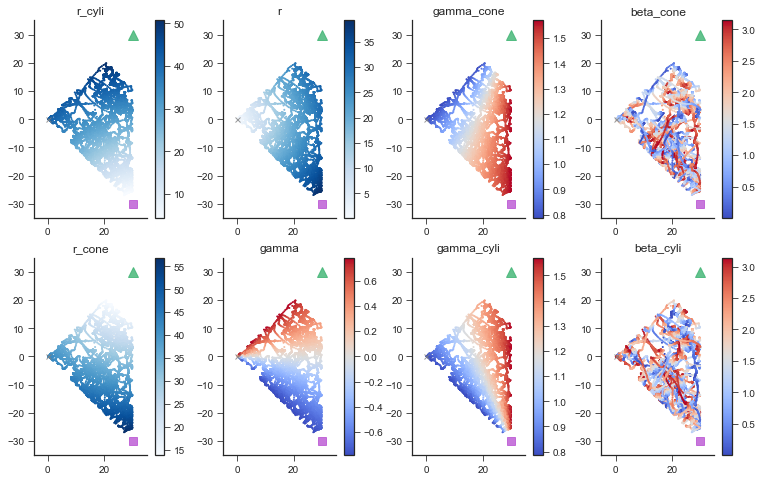

In [1109]:
exdf = ttdf.query('(trial=="train") & (flyID == "'+flyIDs[1]+'")')
# Simple plot for checking accuracy of derrived parameters


fig, axs = plt.subplots(2,4, figsize=(13,8))
visualCheck(axs[0,0], exdf['r_cyli'],'r_cyli', 'Blues') 
visualCheck(axs[1,0],exdf['r_cone'],'r_cone','Blues') 
visualCheck(axs[0,1],exdf['r'],'r', 'Blues') 
visualCheck(axs[1,1],exdf['gamma'],'gamma','coolwarm') 
visualCheck(axs[0,2],exdf['gamma_cone'],'gamma_cone', 'coolwarm') 
visualCheck(axs[1,2],exdf['gamma_cyli'],'gamma_cyli','coolwarm') 
visualCheck(axs[0,3],exdf['beta_cone'],'beta_cone', 'coolwarm') 
visualCheck(axs[1,3],exdf['beta_cyli'],'beta_cyli','coolwarm') 

#### (3.2) Visualization of projection
Trajectory of a single fly in the two projections

In [1110]:
# select example fly
fly = 1
trialtype = 'pre'
exdf = ttdf.query('(trial=="'+trialtype+'") & (flyID == "'+flyIDs[fly]+'")')
exTrialdf = FOAllFlies_df.query('(trialtype=="'+trialtype+'") & (flyID == "'+flyIDs[fly]+'")')

# time to plot
ts = 0
te = 200

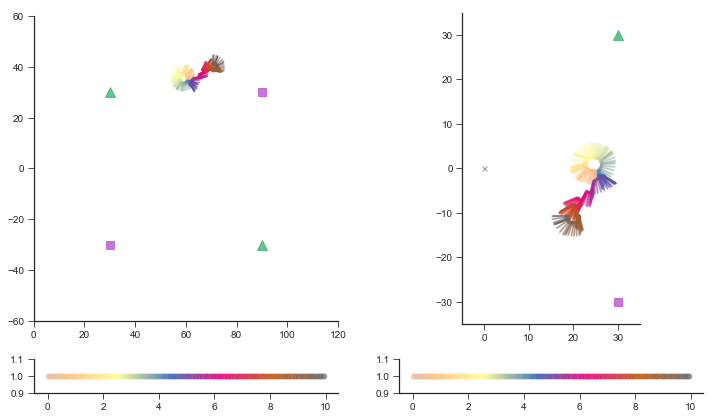

In [1111]:
triangleFig, axs = plt.subplots(2,2,figsize=(12,7),gridspec_kw = {'height_ratios':[9, 1]})

arrowScale = 3
alphaValue = 0.4
markerSize = 5

plotPosInRange(axs[0][0], axs[1][0], np.arange(ts,te), exTrialdf['time'], exTrialdf['xPosInMiniarena'],
               exTrialdf['yPosInMiniarena'], exTrialdf['headingAngle'],
               'Accent', arrowScale, alphaValue, markerSize)
landmarksInSquareTile(axs[0][0])

plotPosInRange(axs[0][1], axs[1][1], np.arange(ts,te), timeTrial, exdf['xt'], exdf['yt'], exdf['alphat'],
               'Accent', arrowScale, alphaValue, markerSize)
landmarksInTriangleTile(axs[0][1])

try:
    mkdir(analysisDir + 'ttVis'+ sep)
except:
    print('Plot directory already exists')
    
triangleFig.savefig(analysisDir +sep +'ttVis' +sep+ genotype + '_' + flyIDs[0][0]
         +'_projectionPath_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

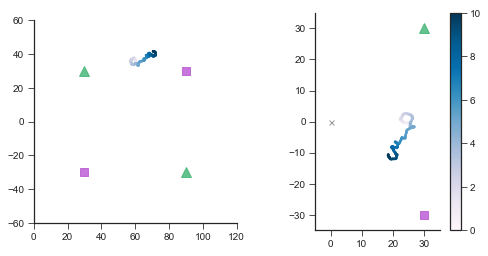

In [1112]:
triangleFig, axs = plt.subplots(1,2,figsize=(8,4))

sc = axs[0].scatter(exTrialdf['xPosInMiniarena'][ts:te], exTrialdf['yPosInMiniarena'][ts:te], s=3, 
                    c=exTrialdf['time'][ts:te],cmap='PuBu', vmin=exTrialdf['time'][ts], vmax=exTrialdf['time'][te])   
cb = plt.colorbar(sc)
landmarksInSquareTile(axs[0])

sc = axs[1].scatter(exdf['xt'][ts:te], exdf['yt'][ts:te], s=3, c=timeTrial[ts:te],
                       cmap='PuBu', vmin=exdf['time'][ts], vmax=exdf['time'][te])
landmarksInTriangleTile(axs[1])


triangleFig.savefig(analysisDir +sep +'ttVis' +sep+ genotype + '_' + flyIDs[0][0]
         +'_projectionPath2_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Residency during movement pooled across flies

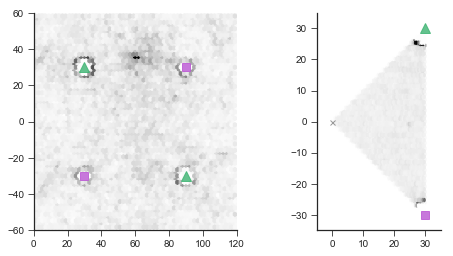

In [1113]:
trialtype = 'train'
exdf = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
exTrialdf = FOAllFlies_df.query('(trialtype=="'+trialtype+'") & (moving > 0)')

triangleFig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].hexbin(exTrialdf['xPosInMiniarena'], exTrialdf['yPosInMiniarena'], gridsize=60, cmap='Greys')
axs[1].hexbin(exdf['xt'], exdf['yt'], gridsize=60, cmap='Greys')
for ax in axs:
    myAxisTheme(ax)
    
for obj in range(2):
    axs[0].plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
    axs[0].plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

landmarksInTriangleTile(axs[1])
    
triangleFig.savefig(analysisDir +sep +'ttVis' +sep+ genotype + '_' + flyIDs[0][0]
         +'_projectionResidency_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

#### (3.3) Consistency check: law of cosines

In [1114]:
lhs = np.cos(ttdf['gamma_cone'].values + ttdf['gamma_cyli'].values)
rhs = ( -np.square(gridSize) + np.square(ttdf['r_cone'].values) + np.square(ttdf['r_cyli'].values) ) / (2*ttdf['r_cone'].values*ttdf['r_cyli'].values) 

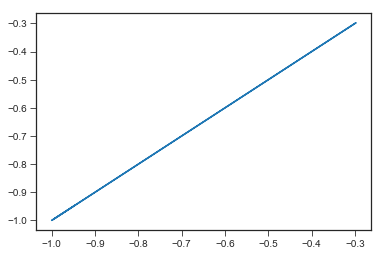

In [1115]:
plt.plot(lhs[:1000],rhs[:1000])

### (3) Compute maps of walking parameter in triangle tile

In [1116]:

rmin = 3
rmax = gridSize - 7

range_cone = [ [np.pi/4, np.pi/2], [rmin, rmax]]
range_cyli = [ [np.pi/4, np.pi/2], [rmin, rmax]]

extent_cone = [rmin, rmax, np.pi/4, np.pi/2]
extent_cyli = [rmin, rmax, np.pi/4, np.pi/2]

rmin = 3
rmax = np.sqrt(gridSize/2 * gridSize/2 * 2) - 7

range_ctr = [ [-np.pi/4, np.pi/4], [rmin, rmax]]
extent_ctr = [rmin, rmax, -np.pi/4, np.pi/4]


histStat = 'median'
numBins = [9,10]

#### Map of residency

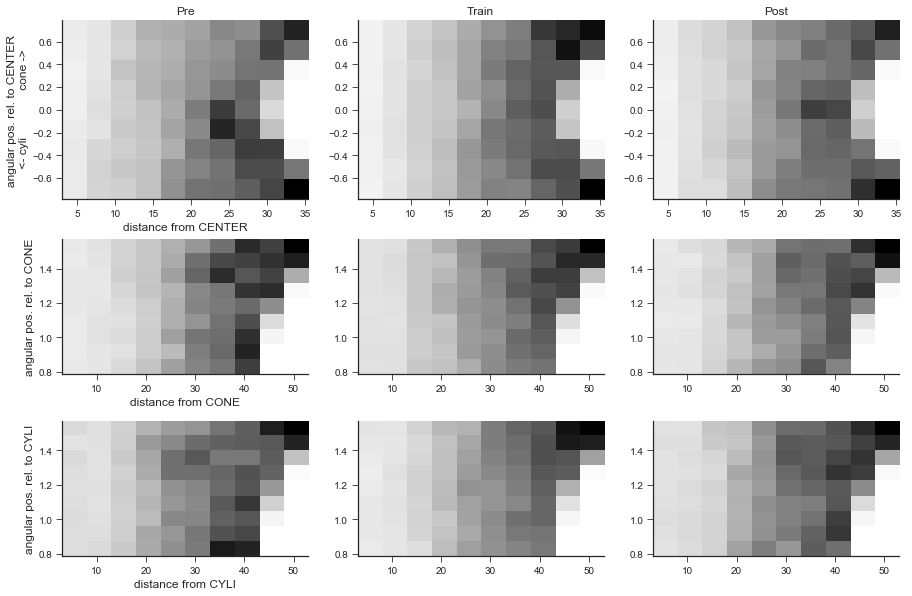

In [1117]:
map2dFig, axs = plt.subplots(3,3, figsize=(15,10), gridspec_kw={'height_ratios':[1.2,1,1]})

for ttind, trialtype in enumerate(trialName):
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                                   bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(H, cmap='Greys', extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15)
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                                   bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(H, cmap='Greys', extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                                   bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(H, cmap='Greys', extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)

    for ax in axs[:][ttind]: myAxisTheme(ax)

try:
    mkdir(analysisDir + 'ttResidency'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttResidency' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileResidency_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

#### Maps of walking velocities

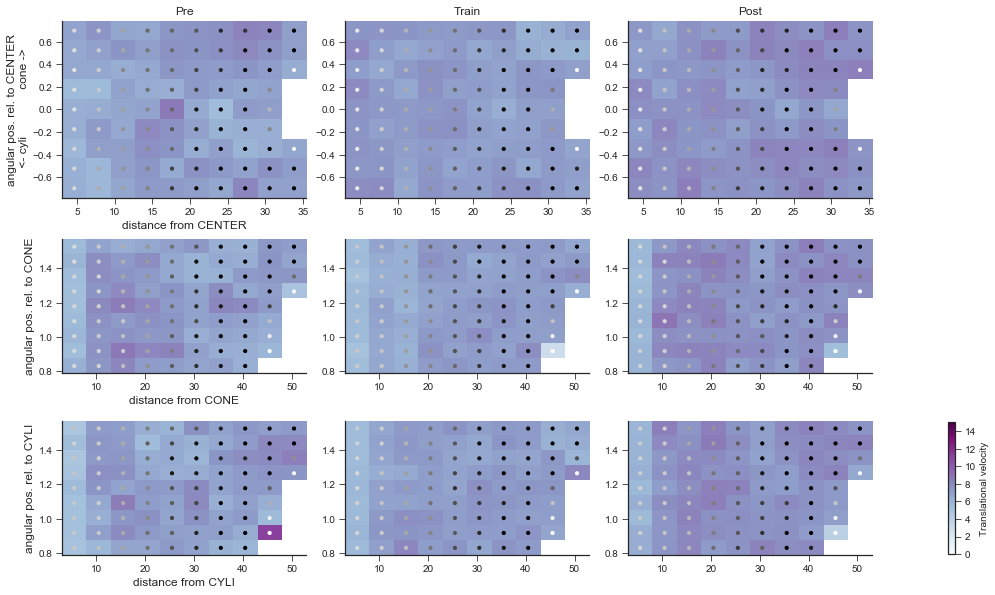

In [1118]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})
maxVT =  15#18
colmap = 'BuPu'
for ttind, trialtype in enumerate(trialName):
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                                    ttdf_tr['transVelo'].values[mask],statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVT, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=0, vmax=maxVT)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                                   bins=numBins, range=range_ctr)
    sampleTH = np.percentile(H,80)
    dy = (extent_ctr[1] - extent_ctr[0])/numBins[1]
    dx = (extent_ctr[3] - extent_ctr[2])/numBins[0]
    xp = np.linspace(extent_ctr[2] + dx/2, extent_ctr[3] - dx/2, numBins[0])
    yp = np.linspace(extent_ctr[0] + dy/2, extent_ctr[1] - dy/2, numBins[1])
    X, Y = np.meshgrid(xp, yp)
    axs[0][ttind].scatter(Y, X,s=10,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)

    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                                    ttdf_tr['transVelo'].values[mask],statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVT, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=0, vmax=maxVT)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                                   bins=numBins, range=range_cone)
    sampleTH = np.percentile(H,80)
    xp = np.linspace(extent_cone[2]+(np.diff(extent_cone[2:]))/(2*avVT.shape[0]), extent_cone[3]-(np.diff(extent_cone[2:]))/(2*avVT.shape[0]), avVT.shape[0])
    yp = np.linspace(extent_cone[0]+(np.diff(extent_cone[:2]))/(2*avVT.shape[1]), extent_cone[1]-(np.diff(extent_cone[:2]))/(2*avVT.shape[1]), avVT.shape[1])
    X, Y = np.meshgrid(xp, yp)
    axs[1][ttind].scatter(Y, X,s=10,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)
    
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                                    ttdf_tr['transVelo'].values[mask],statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVT, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=0, vmax=maxVT)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                                   bins=numBins, range=range_cyli)
    sampleTH = np.percentile(H,80)
    xp = np.linspace(extent_cyli[2]+(np.diff(extent_cyli[2:]))/(2*avVT.shape[0]), extent_cyli[3]-(np.diff(extent_cyli[2:]))/(2*avVT.shape[0]), avVT.shape[0])
    yp = np.linspace(extent_cyli[0]+(np.diff(extent_cyli[:2]))/(2*avVT.shape[1]), extent_cyli[1]-(np.diff(extent_cyli[:2]))/(2*avVT.shape[1]), avVT.shape[1])
    X, Y = np.meshgrid(xp, yp)
    axs[2][ttind].scatter(Y, X,s=10,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)
    
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Translational velocity', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttWalkingVeloMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttWalkingVeloMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileVTrans_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


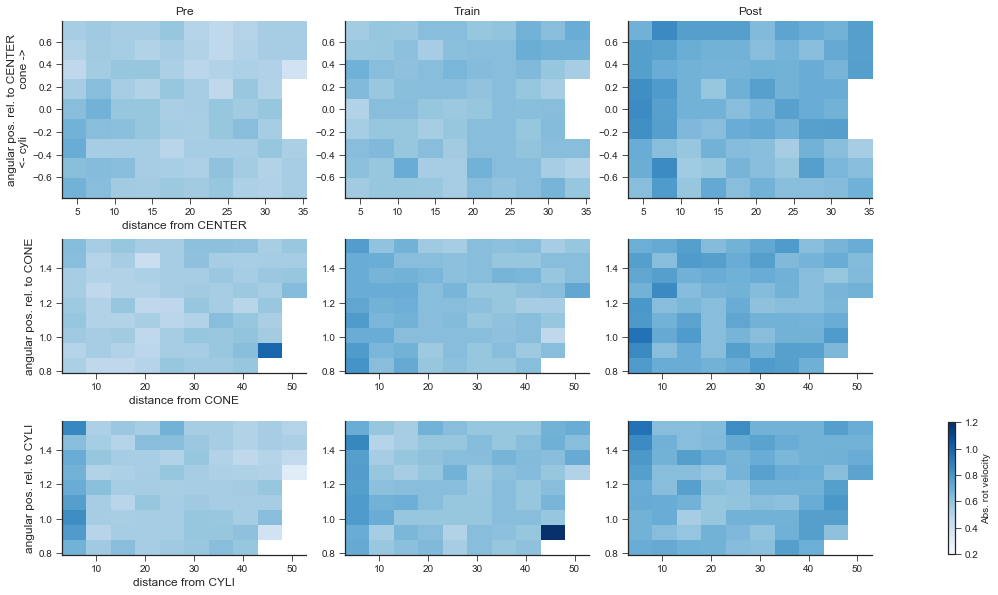

In [1119]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})
maxVal = 1.2
minVal = 0.2
colmap = 'Blues'

for ttind, trialtype in enumerate(trialName):
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                        abs(ttdf_tr['rotVelo'].values[mask]),statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVT, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                        abs(ttdf_tr['rotVelo'].values[mask]),statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVT, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                        abs(ttdf_tr['rotVelo'].values[mask]),statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVT, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)

    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Abs. rot velocity', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttWalkingVeloMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttWalkingVeloMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileVRot_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

#### Maps of relative heading angles

Plot directory already exists


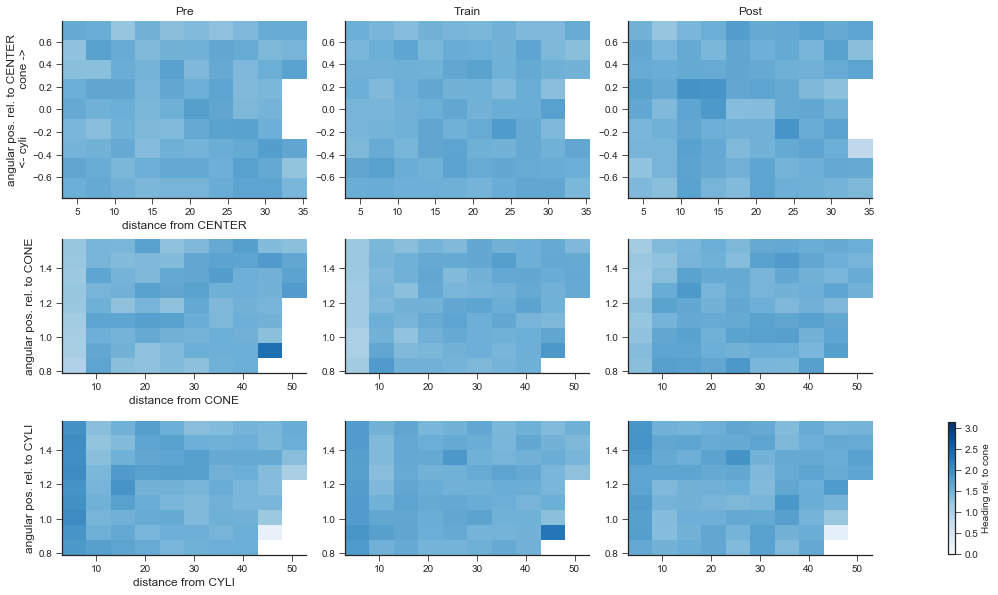

In [1120]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})
colmap = 'Blues'#'RdBu'

refLM = 'cone'

minVal = 0
maxVal = np.pi

for ttind, trialtype in enumerate(trialName):
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                                    ttdf_tr['beta_'+refLM].values[mask],statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVT, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                                    ttdf_tr['beta_cone'].values[mask],statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVT, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                                    ttdf_tr['beta_cone'].values[mask],statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVT, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Heading rel. to '+refLM, ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttWalkingVeloMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttWalkingVeloMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileRelHead_'+refLM+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### (4) Find "reorientation events", defined as continuous periods of  abs(diff(beta)) > 0
Use beta_cone OR beta_cyli for this analysis.

#### Helper functions

In [1121]:
def findzerocrossings(X):
    last_sign = 0
    eventStart = []
    eventEnd = []

    for ind, x in enumerate(X):
        if np.isnan(x):
            continue
            
        currsign = np.sign(x)
        if not currsign == last_sign:
            eventStart.append(ind)
            eventEnd.append(ind-1)
            last_sign = currsign
    return np.asarray(eventStart[:-1]), np.asarray(eventEnd[1:])

#### Illustration

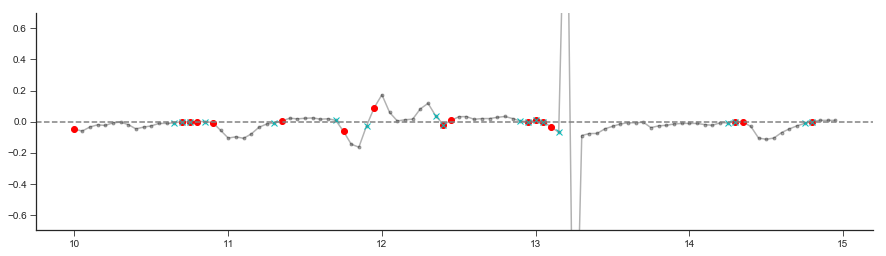

In [1122]:
trialtype = 'pre'
ttdf_tr = ttdf.query('(trial=="'+trialtype+'")')

mask = ~np.isnan(ttdf_tr['gamma'].values)

time_tr = ttdf_tr['time'].values
beta2U = ttdf_tr['alphat'].values.copy()
beta2U[~np.isnan(beta2U)] = np.unwrap(beta2U[~np.isnan(beta2U)])
dbeta = np.hstack((0,np.diff(beta2U)))

#plt.plot(np.mod(beta2U+np.pi, 2*np.pi)[0:1000])
#plt.plot(ttdf_tr['beta_cone'].values[0:1000]+np.pi)

ts = 200
te = 300

evSt_sub, evEd_sub = findzerocrossings(dbeta[ts:te])

fig, axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(time_tr[ts:te],dbeta[ts:te], 'k.-', alpha=0.3)
axs.set_ylim(-0.7,0.7)
axs.plot(time_tr[ts:te][evSt_sub],dbeta[ts:te][evSt_sub], 'ro')
axs.plot(time_tr[ts:te][evEd_sub],dbeta[ts:te][evEd_sub], 'cx')
axs.axhline(y=0, color='grey', linestyle='dashed')
myAxisTheme(axs)

#### Map settings

In [1209]:
histStat = 'median'

minROLength = 1 #5

evAttrib = 'start_min1' #'end_min1'

refLM = 'cyli'

#### Compute reorientation events for each trial

pre
17027
65.2900801411% of events are considered
train
30418
65.8726205687% of events are considered
post
16086
67.3589883171% of events are considered


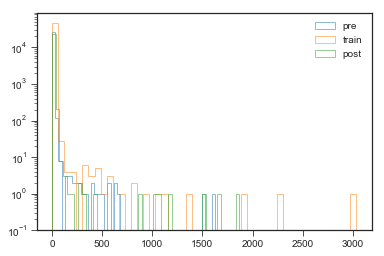

In [1210]:
ROLength = []
ROEffect = []
ROst = []
ROed = []

fig, ax, = plt.subplots(1,1)
    
for ttind, trialtype in enumerate(trialName):
    print(trialtype)
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')

    mask = np.isnan(ttdf_tr['gamma'].values)

    time_tr = ttdf_tr['time'].values
    
    # Compute delta beta
    #    unwrap, where not nan
    beta2U = ttdf_tr['alphat'].values.copy()
    beta2U[~np.isnan(beta2U)] = np.unwrap(beta2U[~np.isnan(beta2U)])
    
    #    take numerical derivative
    dbeta = np.hstack((0,np.diff(beta2U)))
    
    #    block values that are nan in gamma
    dbeta[mask] = np.nan

    evSt, evEd = findzerocrossings(dbeta)
    rawROLength = evEd - evSt

    #plt.plot(allROLength) # debugging plot
    ax.hist(rawROLength,50,histtype='step',log=True, alpha=0.5)

    evSt = evSt[rawROLength >= minROLength]
    evEd = evEd[rawROLength >= minROLength]

    # Reorientation event duration (∆t)
    ROLength_tr = time_tr[evEd] - time_tr[evSt]
    tmp = ROLength_tr<0
    ROLength_tr = ROLength_tr[~tmp]
    evSt = evSt[~tmp]
    evEd = evEd[~tmp]

    print(len(ROLength_tr))
    print(str((100.*len(ROLength_tr))/len(rawROLength)) + '% of events are considered')

    # Reorientation event effect (∆x)
    ROEffect_tr = ttdf_tr['beta_'+refLM].values[evEd] - ttdf_tr['beta_'+refLM].values[evSt]
    ROEffect_tr_abs = abs(ROEffect_tr)%np.pi
    ROEffect_tr = abs(ROEffect_tr)%np.pi * np.sign(ROEffect_tr)

    #plt.hist(ROEffect,100); # debugging plot
    
    ROLength.append(ROLength_tr)
    ROEffect.append(ROEffect_tr)
    ROst.append(evSt)
    ROed.append(evEd)
    
ax.legend(trialName)

In [1211]:
if 'end' in evAttrib:
    ROmapPt = ROed
else:
    ROmapPt = ROst

#### Reorientation Event Count

Plot directory already exists


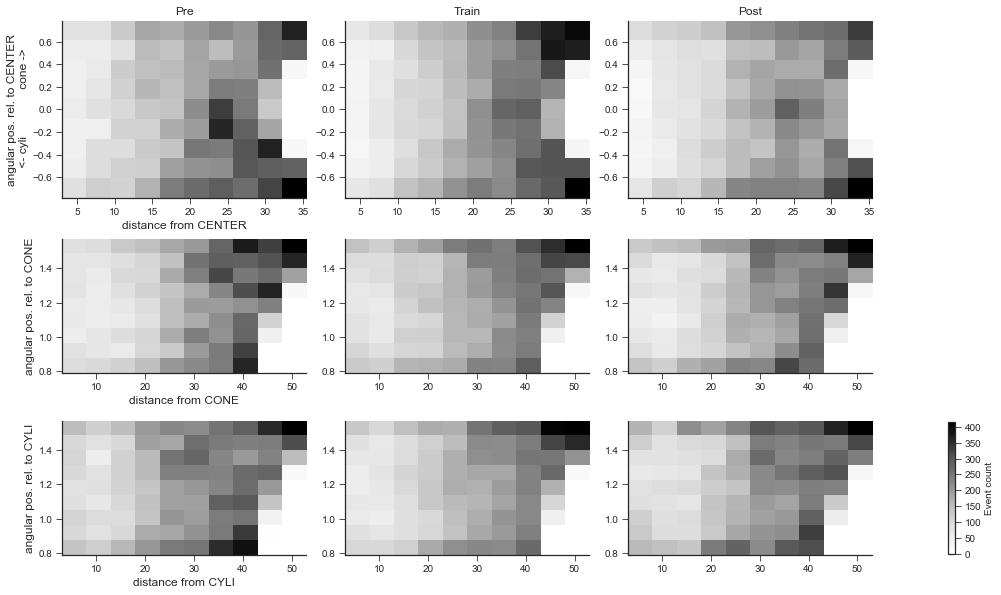

In [1212]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

maxVal = 0.9
minVal = 0

colmap = 'Greys'

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma'].values[ROmapPt[ttind]],ttdf_tr['r'].values[ROmapPt[ttind]],
                                   bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(H, cmap='Greys', extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15)
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]],ttdf_tr['r_cone'].values[ROmapPt[ttind]],
                                   bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(H, cmap='Greys', extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]],ttdf_tr['r_cyli'].values[ROmapPt[ttind]],
                                   bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(H, cmap='Greys', extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35)
    
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event count', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttReorientationMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileROHist_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

#### Reorientation Event Length

Plot directory already exists


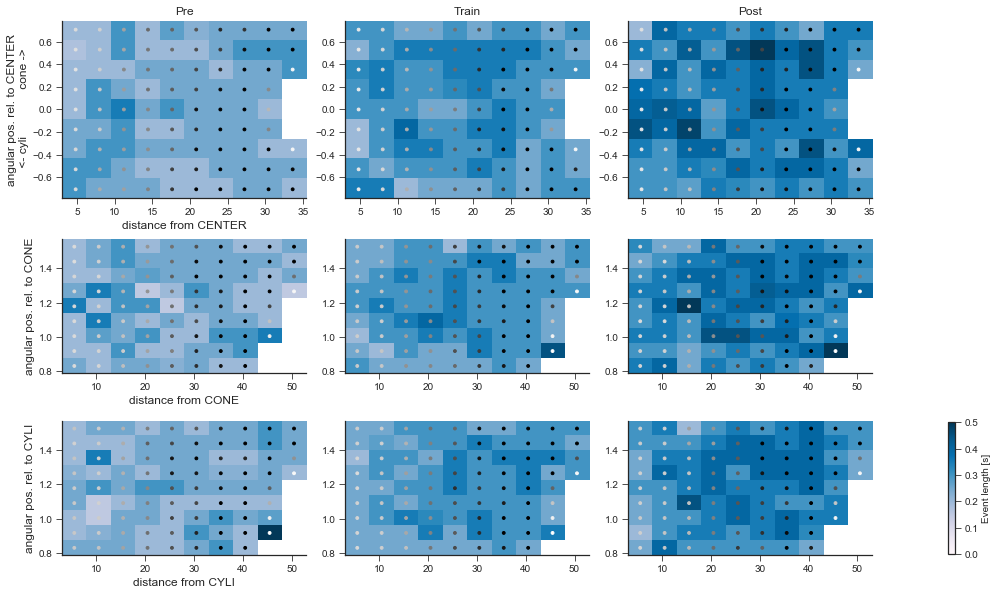

In [1213]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

maxVal = 0.5#0.9#
minVal = 0

colmap = 'PuBu'

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[ROmapPt[ttind]],
            ttdf_tr['r'].values[ROmapPt[ttind]], ROLength[ttind], statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVT, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma'].values[mask],ttdf_tr['r'].values[mask],
                                   bins=numBins, range=range_ctr)
    sampleTH = np.percentile(H,80)
    xp = np.linspace(extent_ctr[2]+(np.diff(extent_ctr[2:]))/(2*numBins[1]), extent_ctr[3]-(np.diff(extent_ctr[2:]))/(2*numBins[1]), avVT.shape[0])
    yp = np.linspace(extent_ctr[0]+(np.diff(extent_ctr[:2]))/(2*numBins[0]), extent_ctr[1]-(np.diff(extent_ctr[:2]))/(2*numBins[0]), avVT.shape[1])
    X, Y = np.meshgrid(xp, yp)
    axs[0][ttind].scatter(Y, X,s=8,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]],
            ttdf_tr['r_cone'].values[ROmapPt[ttind]], ROLength[ttind], statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVT, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cone'].values[mask],ttdf_tr['r_cone'].values[mask],
                                   bins=numBins, range=range_cone)
    sampleTH = np.percentile(H,80)
    xp = np.linspace(extent_cone[2]+(np.diff(extent_cone[2:]))/(2*avVT.shape[0]), extent_cone[3]-(np.diff(extent_cone[2:]))/(2*avVT.shape[0]), avVT.shape[0])
    yp = np.linspace(extent_cone[0]+(np.diff(extent_cone[:2]))/(2*avVT.shape[1]), extent_cone[1]-(np.diff(extent_cone[:2]))/(2*avVT.shape[1]), avVT.shape[1])
    X, Y = np.meshgrid(xp, yp)
    axs[1][ttind].scatter(Y, X,s=8,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)
    
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]],
            ttdf_tr['r_cyli'].values[ROmapPt[ttind]], ROLength[ttind], statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVT, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    
    H, xedg, yedg = np.histogram2d(ttdf_tr['gamma_cyli'].values[mask],ttdf_tr['r_cyli'].values[mask],
                                   bins=numBins, range=range_cyli)
    sampleTH = np.percentile(H,80)
    xp = np.linspace(extent_cyli[2]+(np.diff(extent_cyli[2:]))/(2*avVT.shape[0]), extent_cyli[3]-(np.diff(extent_cyli[2:]))/(2*avVT.shape[0]), avVT.shape[0])
    yp = np.linspace(extent_cyli[0]+(np.diff(extent_cyli[:2]))/(2*avVT.shape[1]), extent_cyli[1]-(np.diff(extent_cyli[:2]))/(2*avVT.shape[1]), avVT.shape[1])
    X, Y = np.meshgrid(xp, yp)
    axs[2][ttind].scatter(Y, X,s=8,c=H.T,cmap='Greys', vmin=0, vmax=sampleTH)
    
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event length [s]', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttReorientationMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileROLenght_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


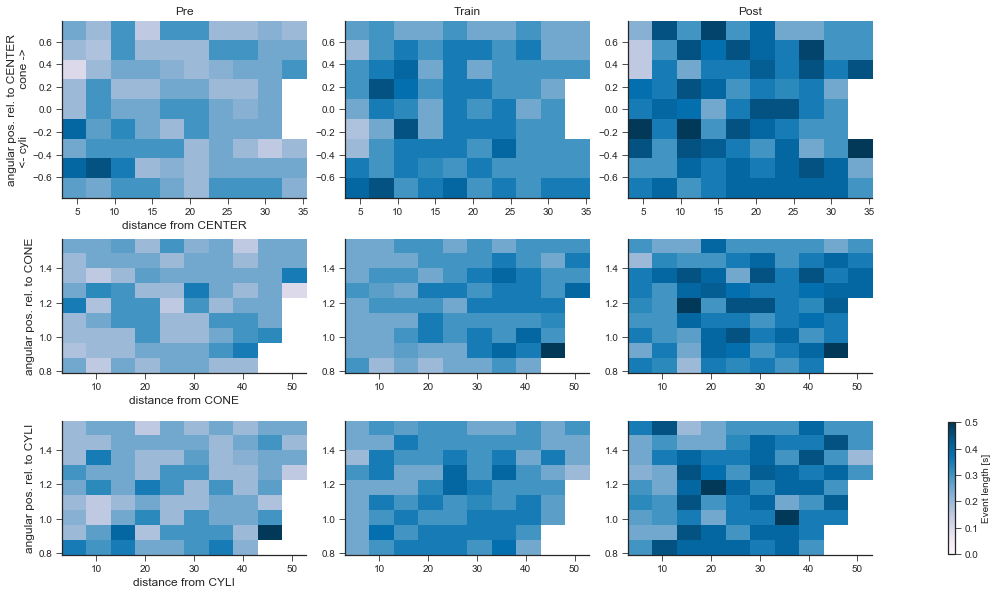

In [1214]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

for ttind, trialtype in enumerate(trialName):

    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'")& (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    slct_FOV = abs(ttdf_tr['beta_cone'].values[ROmapPt[ttind]]) <= np.pi/2
    slct_outFOV = abs(ttdf_tr['beta_cone'].values[ROmapPt[ttind]]) > np.pi/2
    
    # plot rel. to center
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r'].values[ROmapPt[ttind]][slct_FOV], ROLength[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVal, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cone'].values[ROmapPt[ttind]][slct_FOV], ROLength[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVal, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cyli'].values[ROmapPt[ttind]][slct_FOV], ROLength[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVal, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event length [s]', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttReorientationMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileROLenght-coneinFOV_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

# Reorientation Event Effect

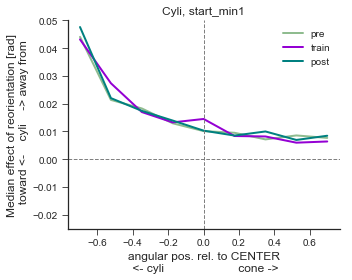

In [1215]:
map2dFig, axs = plt.subplots(1,1, figsize=(5,4))

maxVal = 0.05 #0.2
minVal = -maxVal/2

trialColors = ['darkseagreen', 'darkviolet','teal']

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ROEffect[ttind])
    
    # plot rel. to center
    avVT, xedg, binnum = sts.binned_statistic(ttdf_tr['gamma'].values[ROmapPt[ttind]][mask],
            ROEffect[ttind][mask], statistic=histStat, bins=numBins[0], range=range_ctr[0])
    axs.plot(xedg[:-1]+np.diff(xedg)/2, avVT, linewidth=2, color=trialColors[ttind])
    
axs.set_ylabel('Median effect of reorientation [rad]\n  toward <-    '+refLM+'    -> away from',
                fontsize=12)
axs.set_xlabel('angular pos. rel. to CENTER\n <- cyli                      cone ->', fontsize=12)
axs.set_ylim(minVal,maxVal)
axs.set_title(refLM.capitalize()+', '+evAttrib)
axs.legend(trialName)
axs.axvline(0,0,1,color='grey', linestyle='dashed',linewidth=1)
axs.axhline(0,0,1,color='grey', linestyle='dashed',linewidth=1)
myAxisTheme(axs)

map2dFig.tight_layout()
map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileROEffect_1D_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


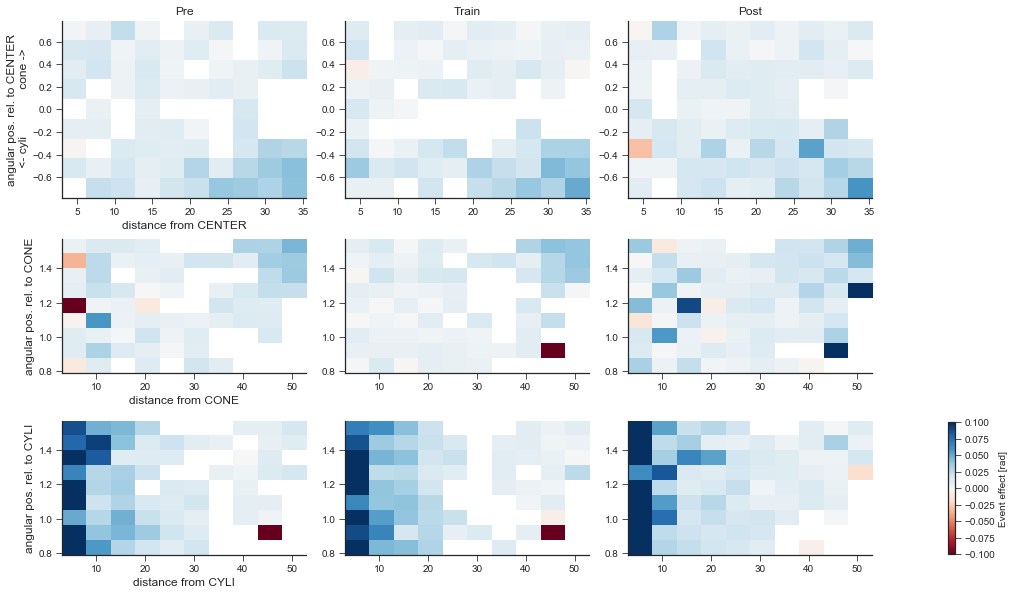

In [1216]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

maxVal = 0.1#0.7
minVal = -maxVal
colmap = 'RdBu'

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'") & (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    # plot rel. to center
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[ROmapPt[ttind]],
            ttdf_tr['r'].values[ROmapPt[ttind]], ROEffect[ttind], statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVT, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]],
            ttdf_tr['r_cone'].values[ROmapPt[ttind]], ROEffect[ttind], statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVT, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVT, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]],
            ttdf_tr['r_cyli'].values[ROmapPt[ttind]], ROEffect[ttind], statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVT, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event effect [rad]', ax = axs[2][3])

try:
    mkdir(analysisDir + 'ttReorientationMap'+ sep)
except:
    print('Plot directory already exists')
    
map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
         +'_triangelTileROEffect_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

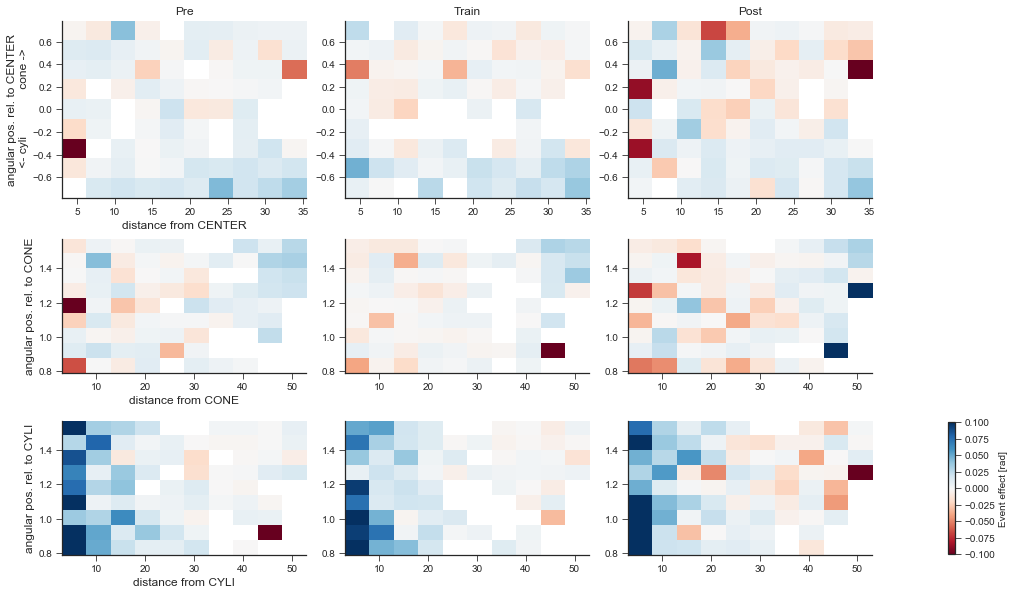

In [1217]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'")& (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    slct_FOV = abs(ttdf_tr['beta_cone'].values[ROmapPt[ttind]]) <= np.pi/2
    
    # plot rel. to center
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVal, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cone'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVal, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cyli'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVal, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event effect [rad]', ax = axs[2][3])

#map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
#         +'_triangelTileROEffect-coneinFOV_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

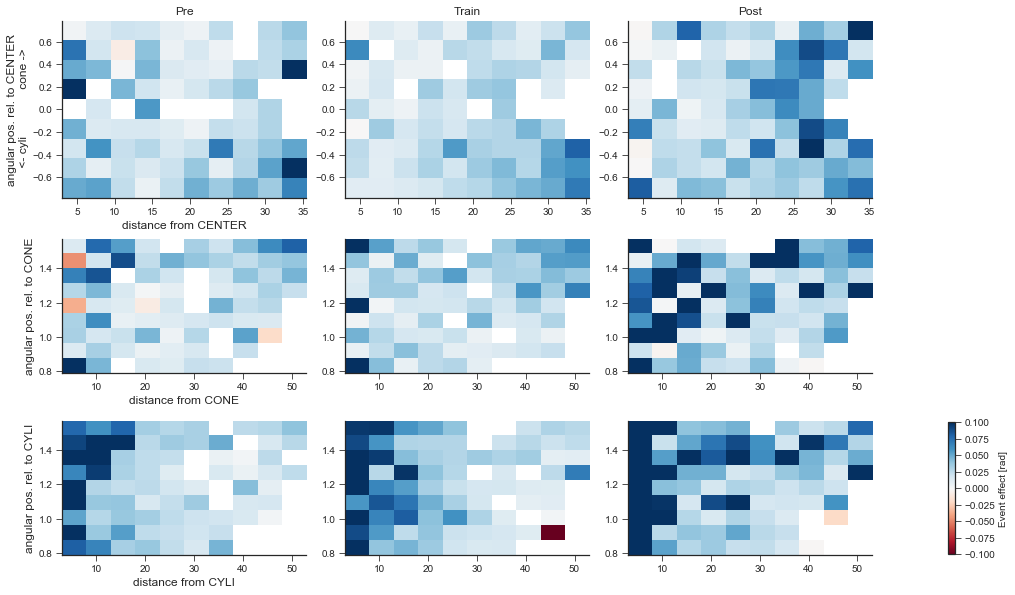

In [1218]:
map2dFig, axs = plt.subplots(3, 4, figsize=(16,10), gridspec_kw={'width_ratios':[5,5,5,0.9],'height_ratios':[1.2,1,1]})

for ttind, trialtype in enumerate(trialName):
    
    #select data for resp. trial
    ttdf_tr = ttdf.query('(trial=="'+trialtype+'")& (moving > 0)')
    mask = ~np.isnan(ttdf_tr['gamma'].values)
    
    slct_FOV = abs(ttdf_tr['beta_cone'].values[ROmapPt[ttind]]) > np.pi/2
    
    # plot rel. to center
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_ctr)
    map2d = axs[0][ttind].imshow(avVal, cmap=colmap, extent=extent_ctr, interpolation='nearest', 
                      origin='lower', aspect=15, vmin=minVal, vmax=maxVal)
    
    if(ttind == 0):
        axs[0][ttind].set_xlabel('distance from CENTER', fontsize=12)
        axs[0][ttind].set_ylabel('angular pos. rel. to CENTER\n <- cyli              cone ->', fontsize=12)
    axs[0][ttind].set_title(trialtype.capitalize())
    
    # plot rel. to cone
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cone'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cone'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cone)
    map2d = axs[1][ttind].imshow(avVal, cmap=colmap, extent=extent_cone, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[1][ttind].set_xlabel('distance from CONE', fontsize=12)
        axs[1][ttind].set_ylabel('angular pos. rel. to CONE', fontsize=12)
    
    # plot rel. to cylinder
    avVal, xedg, yedg, binnum = sts.binned_statistic_2d(ttdf_tr['gamma_cyli'].values[ROmapPt[ttind]][slct_FOV],
            ttdf_tr['r_cyli'].values[ROmapPt[ttind]][slct_FOV], ROEffect[ttind][slct_FOV],
            statistic=histStat, bins=numBins, range=range_cyli)
    map2d = axs[2][ttind].imshow(avVal, cmap=colmap, extent=extent_cyli, interpolation='nearest', 
                      origin='lower', aspect=35, vmin=minVal, vmax=maxVal)
    if(ttind == 0):
        axs[2][ttind].set_xlabel('distance from CYLI', fontsize=12)
        axs[2][ttind].set_ylabel('angular pos. rel. to CYLI', fontsize=12)
    for ax in axs[:][ttind]: myAxisTheme(ax)

for ax in axs[:,3]: ax.axis('off')
cb = plt.colorbar(map2d, label='Event effect [rad]', ax = axs[2][3])


#map2dFig.savefig(analysisDir +sep +'ttReorientationMap' +sep+ genotype + '_' + flyIDs[0][0]
#         +'_triangelTileROEffect-coneoutFOV_'+refLM+'_'+evAttrib+'_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


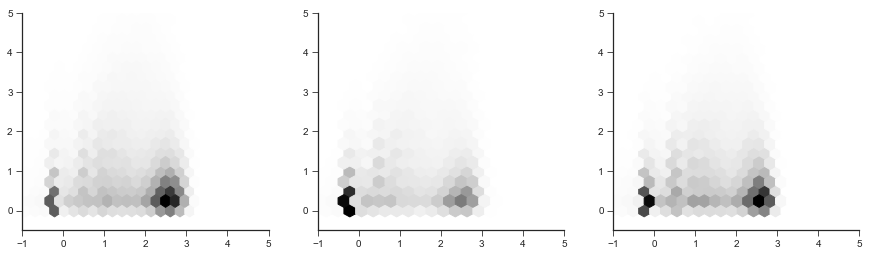

In [46]:
stateFig, axs = plt.subplots(1,3, figsize=(15, 4))

for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '")'
    speed = abs(np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze())
    vR = abs(np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze())
    
    axs[trial].hexbin(np.log(speed), vR, gridsize=(110,130), cmap='Greys')
    axs[trial].set_ylim(-0.5,5)
    axs[trial].set_xlim(-1,5)
    myAxisTheme(axs[trial])

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


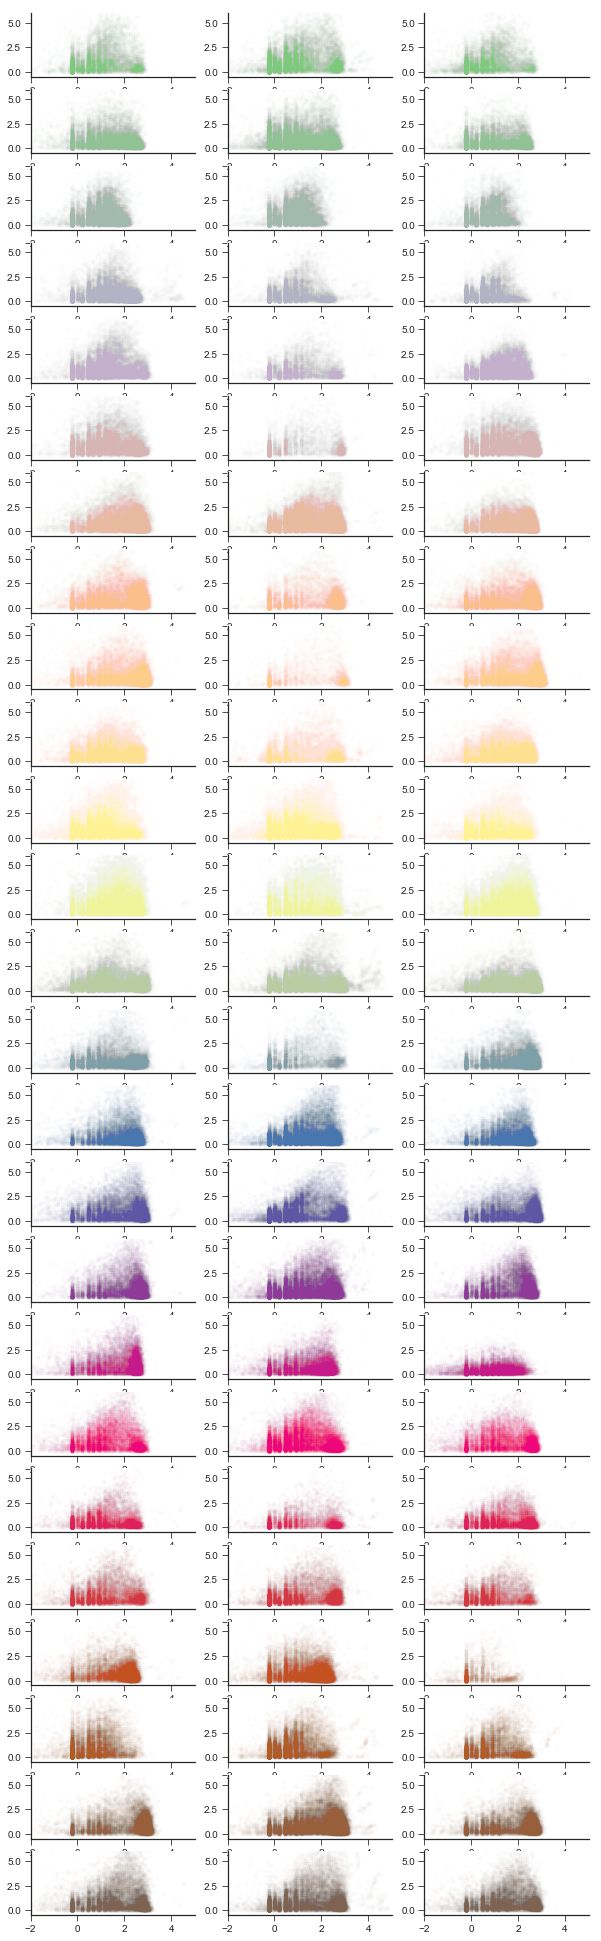

In [47]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

stateFlyFig, axs = plt.subplots(numFlies,3, figsize=(10, 35))

for fly in range(len(flyIDs)):

    for trial, condition in enumerate(trialName):
        querystring = '(trialtype == "' + condition + '" & flyID=="'+flyIDs[fly]+'")'
        speed = abs(np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze())
        vR = abs(np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze())

        axs[fly][trial].plot(np.log(speed), vR, '.', color=flyCMap.to_rgba(fly), alpha=0.01)
        axs[fly][trial].set_ylim(-0.5,6)
        axs[fly][trial].set_xlim(-2,5)
        myAxisTheme(axs[fly][trial])